# Closed-Loop Evaluation
In this notebook you are going to evaluate Urban Driver to control the SDV with a protocol named *closed-loop* evaluation.

**Note: this notebook assumes you've already run the [training notebook](./train.ipynb) and stored your model successfully (or that you have stored a pre-trained one).**

**Note: for a detailed explanation of what closed-loop evaluation (CLE) is, please refer to our [planning notebook](../planning/closed_loop_test.ipynb)**

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from prettytable import PrettyTable

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset

from l5kit.dataset import EgoDatasetVectorized
from l5kit.vectorization.vectorizer_builder import build_vectorizer

from l5kit.simulation.dataset import SimulationConfig
from l5kit.simulation.unroll import ClosedLoopSimulator
from l5kit.cle.closed_loop_evaluator import ClosedLoopEvaluator, EvaluationPlan
from l5kit.cle.metrics import (CollisionFrontMetric, CollisionRearMetric, CollisionSideMetric,
                               DisplacementErrorL2Metric, DistanceToRefTrajectoryMetric)
from l5kit.cle.validators import RangeValidator, ValidationCountingAggregator

from l5kit.visualization.visualizer.zarr_utils import simulation_out_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI

from collections import defaultdict
import os

## Prepare data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params ...).

In [2]:
# set env variable for data
#os.environ["L5KIT_DATA_FOLDER"] = "/tmp/l5kit_data"
os.environ["L5KIT_DATA_FOLDER"] = "/home/jeffrey_wu13579/prediction-dataset"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./config.yaml")

## Load the model

In [3]:
#model_path = "/tmp/urban_driver.pt"
model_path = "/home/jeffrey_wu13579/l5kit/examples/urban_driver/OL_HS_RetrainMLP.pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load(model_path).to(device)
model = model.eval()
torch.set_grad_enabled(False)

/home/jeffrey_wu13579/miniconda3/lib/python3.9/site-packages/torch/serialization.py:602: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


## Load the evaluation data
Differently from training and open loop evaluation, this setting is intrinsically sequential. As such, we won't be using any of PyTorch's parallelisation functionalities.

In [4]:
# ===== INIT DATASET
eval_cfg = cfg["val_data_loader"]
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
vectorizer = build_vectorizer(cfg, dm)
eval_dataset = EgoDatasetVectorized(cfg, eval_zarr, vectorizer)
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  4030296   | 312617887  |    29277930   |      111.97     |        248.48        |        77.57         |        24.85         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+



## Define some simulation properties
We define here some common simulation properties such as the length of the simulation and how many scene to simulate.

**NOTE: these properties have a significant impact on the execution time. We suggest you to increase them only if your setup includes a GPU.**

In [5]:
num_scenes_to_unroll = 1000
num_simulation_steps = 240

# Closed-loop simulation

We define a closed-loop simulation that drives the SDV for `num_simulation_steps` steps while using the log-replayed agents.

Then, we unroll the selected scenes.
The simulation output contains all the information related to the scene, including the annotated and simulated positions, states, and trajectories of the SDV and the agents.  
If you want to know more about what the simulation output contains, please refer to the source code of the class `SimulationOutput`.

In [6]:
# ==== DEFINE CLOSED-LOOP SIMULATION
sim_cfg = SimulationConfig(use_ego_gt=False, use_agents_gt=True, disable_new_agents=True,
                           distance_th_far=500, distance_th_close=50, num_simulation_steps=num_simulation_steps,
                           start_frame_index=0, show_info=True)

sim_loop = ClosedLoopSimulator(sim_cfg, eval_dataset, device, model_ego=model, model_agents=None)

In [7]:
# ==== UNROLL
scenes_to_unroll = list(range(0, len(eval_zarr.scenes), len(eval_zarr.scenes)//num_scenes_to_unroll))
sim_outs = sim_loop.unroll(scenes_to_unroll)

/home/jeffrey_wu13579/miniconda3/lib/python3.9/site-packages/l5kit/data/zarr_dataset.py:213: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = ChunkedDataset("")
/home/jeffrey_wu13579/miniconda3/lib/python3.9/site-packages/l5kit/simulation/utils.py:107: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  new_dataset = ChunkedDataset("")


  0%|          | 0/240 [00:00<?, ?it/s]

# Closed-loop metrics

**Note: for a detailed explanation of CLE metrics, please refer again to our [planning notebook](../planning/closed_loop_test.ipynb)**

In [8]:
metrics = [DisplacementErrorL2Metric(),
           DistanceToRefTrajectoryMetric(),
           CollisionFrontMetric(),
           CollisionRearMetric(),
           CollisionSideMetric()]

validators = [RangeValidator("displacement_error_l2", DisplacementErrorL2Metric, max_value=30),
              RangeValidator("distance_ref_trajectory", DistanceToRefTrajectoryMetric, max_value=4),
              RangeValidator("collision_front", CollisionFrontMetric, max_value=0),
              RangeValidator("collision_rear", CollisionRearMetric, max_value=0),
              RangeValidator("collision_side", CollisionSideMetric, max_value=0)]

intervention_validators = ["displacement_error_l2",
                           "distance_ref_trajectory",
                           "collision_front",
                           "collision_rear",
                           "collision_side"]

cle_evaluator = ClosedLoopEvaluator(EvaluationPlan(metrics=metrics,
                                                   validators=validators,
                                                   composite_metrics=[],
                                                   intervention_validators=intervention_validators))

# Quantitative evaluation

We can now compute the metric evaluation, collect the results and aggregate them.

In [9]:
cle_evaluator.evaluate(sim_outs)
validation_results = cle_evaluator.validation_results()
agg = ValidationCountingAggregator().aggregate(validation_results)
cle_evaluator.reset()

## Reporting errors from the closed-loop

We can now report the metrics and plot them.

+-------------------------+-------+
|          metric         | value |
+-------------------------+-------+
|  displacement_error_l2  |  104  |
| distance_ref_trajectory |  137  |
|     collision_front     |   4   |
|      collision_rear     |  377  |
|      collision_side     |   29  |
+-------------------------+-------+


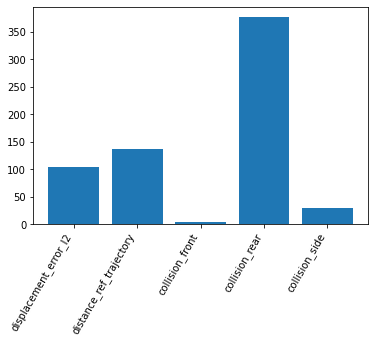

In [10]:
fields = ["metric", "value"]
table = PrettyTable(field_names=fields)

values = []
names = []

for metric_name in agg:
    table.add_row([metric_name, agg[metric_name].item()])
    values.append(agg[metric_name].item())
    names.append(metric_name)

print(table)

plt.bar(np.arange(len(names)), values)
plt.xticks(np.arange(len(names)), names, rotation=60, ha='right')
plt.show()

# Qualitative evaluation

## Visualise the closed-loop

We can visualise the scenes we have obtained previously. 

**The policy is now in full control of the SDV as this moves through the annotated scene.**

In [ ]:
output_notebook()
mapAPI = MapAPI.from_cfg(dm, cfg)
for sim_out in sim_outs: # for each scene
    vis_in = simulation_out_to_visualizer_scene(sim_out, mapAPI)
    show(visualize(sim_out.scene_id, vis_in))